# Setup & Load Data

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from __future__ import annotations
from pathlib import Path
import json
import math
import time
import re
import os
import hashlib
import unicodedata
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import normalize
from scipy.sparse import load_npz
import joblib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Markdown

In [ ]:
ROOT = Path(".").resolve()

DATA_DIR = ROOT / "Data"
PROCESSED_DIR = ROOT / "DataAfterProcessing" / "Processed"

MODELS_DIR = ROOT / "Models"
CONTENT_DIR = MODELS_DIR / "Content"
RULES_DIR = MODELS_DIR / "Rules"
LLM_DIR = MODELS_DIR / "LLMs"

# Tạo thư mục nếu thiếu (không tạo file mới, chỉ tạo folder cache nếu cần)
for d in [DATA_DIR, PROCESSED_DIR, MODELS_DIR, CONTENT_DIR, RULES_DIR, LLM_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("CONTENT_DIR:", CONTENT_DIR)
print("RULES_DIR:", RULES_DIR)
print("LLM_DIR:", LLM_DIR)

ROOT: D:\TDTU\IV - HK1\DACNTT
PROCESSED_DIR: D:\TDTU\IV - HK1\DACNTT\DataAfterProcessing\Processed
CONTENT_DIR: D:\TDTU\IV - HK1\DACNTT\Models\Content
RULES_DIR: D:\TDTU\IV - HK1\DACNTT\Models\Rules
LLM_DIR: D:\TDTU\IV - HK1\DACNTT\Models\LLMs


In [ ]:
pd.set_option("display.max_colwidth", 80)
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 60)

def strip_spaces(s: str) -> str:
    s = str(s) if s is not None else ""
    s = re.sub(r"\s+", " ", s).strip()
    return s

def remove_accents_keep_original(text: str) -> str:
    """
    Trả về chuỗi không dấu (để char-tfidf ổn định). 
    Không “mix” bản gốc + không dấu để tránh bơm nhiễu.
    """
    
    text = str(text) if text is not None else ""
    text = unicodedata.normalize("NFD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")
    return unicodedata.normalize("NFC", text)

def safe_lower(s: str) -> str:
    return strip_spaces(s).lower()

def ensure_cols(df: pd.DataFrame, required: List[str], name: str):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"[{name}] Missing columns: {missing}. Existing: {df.columns.tolist()}")

def as_str_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip()

def topk_idx(scores: np.ndarray, k: int) -> np.ndarray:
    if k <= 0:
        return np.array([], dtype=int)
    k = min(k, scores.shape[0])
    # Argpartition nhanh hơn sort full
    idx = np.argpartition(-scores, kth=k-1)[:k]
    idx = idx[np.argsort(-scores[idx])]
    return idx

In [ ]:
# Load processed products & rules
products_path = PROCESSED_DIR / "products_enriched.csv"
transactions_path = PROCESSED_DIR / "transactions_long.csv"

item_rules_path = RULES_DIR / "item_rules.csv"
cat_rules_path  = RULES_DIR / "category_rules.csv"

for p in [products_path, transactions_path, item_rules_path, cat_rules_path]:
    if not p.exists():
        raise FileNotFoundError(f"Không thấy file: {p}")

products = pd.read_csv(products_path)
transactions = pd.read_csv(transactions_path)
item_rules = pd.read_csv(item_rules_path)
cat_rules  = pd.read_csv(cat_rules_path)

# Validate schema
ensure_cols(products, [
    "product_id_str", "product_name_vi", "price",
    "brand_name", "category_name", "parent_category_name",
    "full_metadata"
], "products_enriched")

ensure_cols(transactions, [
    "bill_id", "product_id_str", "product_name_vi"
], "transactions_long")

ensure_cols(item_rules, [
    "antecedent_id", "consequent_id", "support", "confidence", "lift",
    "antecedent_name", "consequent_name"
], "item_rules")

ensure_cols(cat_rules, [
    "ante_parent_cat", "cons_parent_cat", "support", "confidence", "lift"
], "category_rules")

# Normalize id types
products["product_id_str"] = as_str_series(products["product_id_str"])
transactions["product_id_str"] = as_str_series(transactions["product_id_str"])
item_rules["antecedent_id"] = as_str_series(item_rules["antecedent_id"])
item_rules["consequent_id"] = as_str_series(item_rules["consequent_id"])
cat_rules["ante_parent_cat"] = cat_rules["ante_parent_cat"].astype(str)
cat_rules["cons_parent_cat"] = cat_rules["cons_parent_cat"].astype(str)

print("products:", products.shape)
print("transactions:", transactions.shape)
print("item_rules:", item_rules.shape)
print("category_rules:", cat_rules.shape)

display(products.head(3))
display(transactions.head(3))

products: (12877, 15)
transactions: (49786, 11)
item_rules: (258, 11)
category_rules: (869, 9)


,product_id_str,barcode,product_name_vi,price,brand_name,country_name,category_id,category_name,parent_category_id,parent_category_name,category_path,description,full_metadata,n_appear,popularity_norm
0,68311cba419bc51ab2ee5aa3,8934868172239,Dầu Gội Nam Sạch Gàu Clear Men Hương Gió Biển và Hổ Phách Chai 840G,249000,Clear Men,UNKNOWN_COUNTRY,682fdf11419bc50c9f24af11,"Dầu Gội, Dầu Xả",682fdf06419bc50c9f24aefb,Chăm Sóc Tóc,"Chăm Sóc Cá Nhân > Chăm Sóc Nam Giới > Chăm Sóc Tóc > Dầu Gội, Dầu Xả","ƯU ĐIỂM NỔI BẬT:– SẠCH GÀU, HẾT NGỨA:Công nghệ sạch gàu 3 tác động đánh bay ...",Dầu Gội Nam Sạch Gàu Clear Men Hương Gió Biển và Hổ Phách Chai 840G | Clear ...,5,0.078125
1,68311cba419bc51ab2ee5aa5,8934868152576,Dầu Gội Sạch Gàu Clear Bạc Hà Mát Lạnh Chai 1.4kg,370000,Clear,UNKNOWN_COUNTRY,682fdf11419bc50c9f24af11,"Dầu Gội, Dầu Xả",682fdf06419bc50c9f24aefb,Chăm Sóc Tóc,"Chăm Sóc Cá Nhân > Chăm Sóc Nam Giới > Chăm Sóc Tóc > Dầu Gội, Dầu Xả","Thời tiết nóng ẩm cùng khói bụi là nguyên nhân chính gây ra gàu, khiến bạn m...",Dầu Gội Sạch Gàu Clear Bạc Hà Mát Lạnh Chai 1.4kg | Clear | Chăm Sóc Cá Nhân...,6,0.093750
2,68311cbb419bc51ab2ee5aa6,8934868172253,Dầu Gội Nam Sạch Gàu Clear Men Hương Phong Lữ và Gỗ Đàn Hương Chai 840G,249000,Clear Men,UNKNOWN_COUNTRY,682fdf11419bc50c9f24af11,"Dầu Gội, Dầu Xả",682fdf06419bc50c9f24aefb,Chăm Sóc Tóc,"Chăm Sóc Cá Nhân > Chăm Sóc Nam Giới > Chăm Sóc Tóc > Dầu Gội, Dầu Xả",Đặc điểm sản phẩm:Dầu Gội Sạch Gàu CLEAR MEN Perfume Warm Forest 840g gây ấn...,Dầu Gội Nam Sạch Gàu Clear Men Hương Phong Lữ và Gỗ Đàn Hương Chai 840G | Cl...,5,0.078125


,bill_id,barcode,product_id_str,product_name_vi,price,brand_name,country_name,category_id,category_name,parent_category_name,category_path
0,0,9300658408526,683129de419bc51ab2ee7179,Sữa Chua Ăn Kiểu Hy Lạp Farmers Union Vị Vani Hũ 90G,20900,FARMERS UNION,Australia,682fdceb419bc5d02ce660e4,Sữa Chua Ăn,"Sữa Chua, Váng Sữa","Chế Phẩm Từ Sữa > Sữa > Sữa Chua, Váng Sữa > Sữa Chua Ăn"
1,0,8935212813020,68312d8e419bc51ab2ee7760,Sữa Tắm Romano Classic Sạch Khuẩn 650g,185900,Wipro,UNKNOWN_COUNTRY,682fdf11419bc50c9f24af0f,"Tắm, Gội",Làm Sạch Cơ Thể,"Chăm Sóc Cá Nhân > Chăm Sóc Nam Giới > Làm Sạch Cơ Thể > Tắm, Gội"
2,0,8850157400107,68312f1a419bc51ab2ee79e3,Snack Mực Tẩm Gia Vị Cay Ngọt Bento 18g,28500,UNKNOWN_BRAND,UNKNOWN_COUNTRY,682fde17419bc5e8a44ee68b,Bánh Snack,"Snack, Ăn Vặt","Bánh Kẹo > Snack, Ăn Vặt > Bánh Snack"


In [4]:
prod_ids = set(products["product_id_str"].tolist())
ante_ids = set(item_rules["antecedent_id"].tolist())

item_rule_coverage = len(prod_ids & ante_ids) / max(1, len(prod_ids))

parent_cats = set(products["parent_category_name"].astype(str).tolist())
ante_cats = set(cat_rules["ante_parent_cat"].astype(str).tolist())
cat_rule_coverage = len(parent_cats & ante_cats) / max(1, len(parent_cats))

print(f"Item-rule coverage (tỉ lệ product có outgoing rule): {item_rule_coverage:.4f}")
print(f"Category-rule coverage (tỉ lệ parent_cat có outgoing rule): {cat_rule_coverage:.4f}")

display(Markdown("**Top item rules by lift**"))
display(item_rules.sort_values(["lift","confidence"], ascending=False).head(5))

display(Markdown("**Top category rules by lift**"))
display(cat_rules.sort_values(["lift","confidence"], ascending=False).head(5))


Item-rule coverage (tỉ lệ product có outgoing rule): 0.0064
Category-rule coverage (tỉ lệ parent_cat có outgoing rule): 0.8851


**Top item rules by lift**

,antecedent_id,consequent_id,co_count,ante_count,cons_count,support,confidence,lift,leverage,antecedent_name,consequent_name
0,68312cde419bc51ab2ee7649,68312802419bc51ab2ee6e77,5,12,24,0.001129,0.416667,76.909722,0.001114,Bột Giặt Surf Hương Nước Hoa Quyến Rũ Túi 5.3kg,Nước Xả Vải Lix Sạch Thơm Ngàn Hoa Túi 2.2L
1,68312802419bc51ab2ee6e77,68312cde419bc51ab2ee7649,5,24,12,0.001129,0.208333,76.909722,0.001114,Nước Xả Vải Lix Sạch Thơm Ngàn Hoa Túi 2.2L,Bột Giặt Surf Hương Nước Hoa Quyến Rũ Túi 5.3kg
2,6831396e419bc51ab2ee8a09,6831230f419bc51ab2ee65f9,7,18,44,0.001580,0.388889,39.154040,0.001540,Khăn Giấy Bếp Đa Năng Fairy 2 Lớp 100 Tờ,Giấy Vệ Sinh Gấu Trúc Silkwell Tre 3 Lớp 10 Cuộn Có Lõi
3,6831230f419bc51ab2ee65f9,6831396e419bc51ab2ee8a09,7,44,18,0.001580,0.159091,39.154040,0.001540,Giấy Vệ Sinh Gấu Trúc Silkwell Tre 3 Lớp 10 Cuộn Có Lõi,Khăn Giấy Bếp Đa Năng Fairy 2 Lớp 100 Tờ
4,68312772419bc51ab2ee6d81,68312309419bc51ab2ee65ef,5,13,45,0.001129,0.384615,37.863248,0.001099,Nước Giặt OMO Matic Cửa Trước Giữ Màu Túi 4.1kg,Giấy Vệ Sinh E'mos Classic 2 Lớp Lốc 10 Cuộn


**Top category rules by lift**

,ante_parent_cat,cons_parent_cat,co_count,ante_count,cons_count,support,confidence,lift,leverage
0,Điện Gia Dụng,Trà,8,24,311,0.001806,0.333333,4.748124,0.001426
1,Thịt Bò,"Xả Vải, Xịt Vải, Nước Tẩy",46,54,829,0.010384,0.851852,4.552115,0.008103
2,"Bột Giặt, Nước Giặt, Viên Giặt","Xả Vải, Xịt Vải, Nước Tẩy",652,812,829,0.147178,0.802956,4.290825,0.112878
3,"Xả Vải, Xịt Vải, Nước Tẩy","Bột Giặt, Nước Giặt, Viên Giặt",652,829,812,0.147178,0.786490,4.290825,0.112878
4,Thịt Bò,"Bánh Bao, Giò Chả, Đậu Hủ",13,54,252,0.002935,0.240741,4.232069,0.002241


In [ ]:
# Load Content-based Artifacts
pindex_path = CONTENT_DIR / "product_index.csv"
tfidf_word_path = CONTENT_DIR / "tfidf_word.joblib"
tfidf_char_path = CONTENT_DIR / "tfidf_char.joblib"
X_word_path = CONTENT_DIR / "X_word.npz"
X_char_path = CONTENT_DIR / "X_char.npz"

for p in [pindex_path, tfidf_word_path, tfidf_char_path, X_word_path, X_char_path]:
    if not p.exists():
        raise FileNotFoundError(f"Thiếu artifact content index: {p}")

product_index = pd.read_csv(pindex_path)
ensure_cols(product_index, ["product_id_str"], "product_index")

# Nếu file product_index có name/meta thì dùng; nếu không có thì join từ products_enriched
if "product_name_vi" not in product_index.columns:
    product_index = product_index.merge(
        products[["product_id_str","product_name_vi","price","brand_name","category_name","parent_category_name","full_metadata"]],
        on="product_id_str",
        how="left"
    )

word_vec = joblib.load(tfidf_word_path)
char_vec = joblib.load(tfidf_char_path)
X_word = load_npz(X_word_path)
X_char = load_npz(X_char_path)

print("product_index:", product_index.shape)
print("X_word:", X_word.shape, "X_char:", X_char.shape)
display(product_index.head(3))

product_index: (12877, 8)
X_word: (12877, 128146) X_char: (12877, 88843)


,product_id_str,row_idx,product_name_vi,price,brand_name,category_name,parent_category_name,full_metadata
0,68311cba419bc51ab2ee5aa3,0,Dầu Gội Nam Sạch Gàu Clear Men Hương Gió Biển và Hổ Phách Chai 840G,249000,Clear Men,"Dầu Gội, Dầu Xả",Chăm Sóc Tóc,Dầu Gội Nam Sạch Gàu Clear Men Hương Gió Biển và Hổ Phách Chai 840G | Clear ...
1,68311cba419bc51ab2ee5aa5,1,Dầu Gội Sạch Gàu Clear Bạc Hà Mát Lạnh Chai 1.4kg,370000,Clear,"Dầu Gội, Dầu Xả",Chăm Sóc Tóc,Dầu Gội Sạch Gàu Clear Bạc Hà Mát Lạnh Chai 1.4kg | Clear | Chăm Sóc Cá Nhân...
2,68311cbb419bc51ab2ee5aa6,2,Dầu Gội Nam Sạch Gàu Clear Men Hương Phong Lữ và Gỗ Đàn Hương Chai 840G,249000,Clear Men,"Dầu Gội, Dầu Xả",Chăm Sóc Tóc,Dầu Gội Nam Sạch Gàu Clear Men Hương Phong Lữ và Gỗ Đàn Hương Chai 840G | Cl...


# Retrieval System (Traditional Base)

In [ ]:
def cosine_scores(query_text: str, w_word=0.65, w_char=0.35) -> np.ndarray:
    q = safe_lower(query_text)
    qw = normalize(word_vec.transform([q]))
    qc = normalize(char_vec.transform([remove_accents_keep_original(q)]))
    sw = (X_word @ qw.T).toarray().ravel()
    sc = (X_char @ qc.T).toarray().ravel()
    return (w_word * sw + w_char * sc)

def content_search(query_text: str, k=20) -> pd.DataFrame:
    scores = cosine_scores(query_text)
    idx = topk_idx(scores, k)
    out = product_index.iloc[idx].copy()
    out["content_score"] = scores[idx]
    # Enrich full info (đảm bảo có price/brand/cat)
    out = out.merge(
        products[["product_id_str","product_name_vi","price","brand_name","category_name","parent_category_name"]],
        on="product_id_str",
        how="left",
        suffixes=("","_p")
    )
    # Fix nulls
    out["product_name_vi"] = out["product_name_vi"].fillna(out.get("product_name_vi_p",""))
    out.drop(columns=[c for c in out.columns if c.endswith("_p")], inplace=True, errors="ignore")
    return out.sort_values("content_score", ascending=False).reset_index(drop=True)

# Quick sanity
display(content_search("tối nay nấu phở trộn", k=8)[["product_id_str","product_name_vi","price","parent_category_name","content_score"]])

,product_id_str,product_name_vi,price,parent_category_name,content_score
0,68312d66419bc51ab2ee771a,Phở Trộn Long Triều Hải Sản Cay Vifon Gói 90G,14500,"Mì, Bún, Topokki Ăn Liền",0.229690
1,68312d66419bc51ab2ee771b,Phở Trộn Long Triều Bò Tái Lăn Vifon Gói 90G,14500,"Mì, Bún, Topokki Ăn Liền",0.228517
2,68312153419bc51ab2ee6300,Phở Bò,45000,Món Ăn Nhanh,0.213040
3,68312698419bc51ab2ee6c0e,Bánh Phở Khô Tam Nông Gói 300G,11400,"Mì, Bún, Nui Khô",0.208298
4,683125cc419bc51ab2ee6ab5,Bột Gia Vị Hoàn Chỉnh Phở Sâm Ngọc Linh Trân Châu Gói 65G,15900,"Sốt, Gia Vị Các Loại",0.197257
5,68312d52419bc51ab2ee76fc,Phở Bò Vifon Tô 120g,30500,"Mì, Bún, Topokki Ăn Liền",0.190981
6,68312d5e419bc51ab2ee7710,Phở Khô Phở Story Gói 500G,34100,"Mì, Bún, Topokki Ăn Liền",0.189341
7,68312d66419bc51ab2ee771e,Phở Trộn Cung Đình Kool Bò Xốt Tương Đen 80G,13900,"Mì, Bún, Topokki Ăn Liền",0.187719


In [ ]:
# Rule-based Intent Detection (Lite Planner)
INTENT_KEYWORDS = {
    "cook":     ["nấu","làm","món","canh","xào","kho","chiên","lẩu","nướng","nguyên liệu"],
    "snack":    ["ăn vặt","snack","xem phim","kẹo","bánh","nước ngọt"],
    "skincare": ["da","mụn","sữa rửa mặt","kem chống nắng","tẩy trang","serum","dưỡng"],
    "laundry":  ["giặt","nước giặt","bột giặt","nước xả","xả vải"],
    "cleaning": ["lau","dọn","tẩy","vệ sinh","lau sàn","rửa chén"],
    "gift":     ["tặng","quà","biếu","sinh nhật","noel","valentine","20/11"],
    "mom_baby": ["bé","bỉm","tã","sữa bột","trẻ em","mẹ"],
    "pet":      ["chó","mèo","thú cưng","cát vệ sinh","pate"]
}

def detect_intent_lite(q: str) -> Tuple[str, Dict[str,int]]:
    ql = safe_lower(q)
    scores = {k: 0 for k in INTENT_KEYWORDS}
    for intent, kws in INTENT_KEYWORDS.items():
        for kw in kws:
            if kw in ql:
                scores[intent] += 1
    best_intent, best_score = max(scores.items(), key=lambda x: x[1])
    return (best_intent if best_score > 0 else "search"), scores

def parse_budget_vnd(q: str) -> Optional[int]:
    q2 = safe_lower(q).replace(".", "").replace(",", "")
    m = re.search(r"(dưới|<|<=)\s*(\d+)\s*(k|nghìn|tr|triệu)?", q2)
    if not m:
        return None
    val = int(m.group(2))
    unit = m.group(3)
    if unit in ["k","nghìn"]:
        return val * 1000
    if unit in ["tr","triệu"]:
        return val * 1000000
    return val

def parse_people(q: str) -> Optional[int]:
    m = re.search(r"(\d+)\s*(người|nguoi)", safe_lower(q))
    return int(m.group(1)) if m else None

def extract_excludes(q: str) -> List[str]:
    """
    Ưu tiên lấy phần đối tượng bị loại trừ, không giữ 'mua'/'đừng'...
    """
    ql = safe_lower(q)
    out = []
    # ví dụ: "đừng mua cá lóc" -> "cá lóc"
    patterns = [
        r"(đừng mua|không mua|trừ)\s+([^,;.]+)",
        r"(không)\s+([^,;.]+)"
    ]
    for pat in patterns:
        for m in re.finditer(pat, ql):
            phrase = strip_spaces(m.group(2))
            phrase = re.sub(r"^(mua|lấy)\s+", "", phrase).strip()
            if phrase and phrase not in out:
                out.append(phrase)
    return out[:8]

class QueryInterpreterLite:
    def analyze(self, query_raw: str) -> Dict:
        intent, scores = detect_intent_lite(query_raw)
        b = parse_budget_vnd(query_raw)
        ppl = parse_people(query_raw)
        return {
            "query_raw": query_raw,
            "query_norm": safe_lower(query_raw),
            "intent": intent,
            "intent_scores": scores,
            "include_terms": [],  # Lite không "bịa" terms, chỉ dùng query_norm
            "exclude_terms": extract_excludes(query_raw),
            "constraints": {
                "budget_max": b,
                "quantity_people": ppl
            },
            "action_hint": strip_spaces(query_raw)[:80]
        }

qi_lite = QueryInterpreterLite()
qi_lite.analyze("muốn nấu canh chua cho 4 người ăn, đừng mua cá lóc")


{'query_raw': 'muốn nấu canh chua cho 4 người ăn, đừng mua cá lóc',
 'query_norm': 'muốn nấu canh chua cho 4 người ăn, đừng mua cá lóc',
 'intent': 'cook',
 'intent_scores': {'cook': 2,
  'snack': 0,
  'skincare': 0,
  'laundry': 0,
  'cleaning': 0,
  'gift': 0,
  'mom_baby': 0,
  'pet': 0},
 'include_terms': [],
 'exclude_terms': ['cá lóc'],
 'constraints': {'budget_max': None, 'quantity_people': 4},
 'action_hint': 'muốn nấu canh chua cho 4 người ăn, đừng mua cá lóc'}

# LLM Integration (GEMINI)

In [ ]:
# === CÁCH 1: Set env trước khi chạy notebook ===
# Windows (PowerShell):
#   setx GEMINI_API_KEY "YOUR_KEY"
#

# === CÁCH 2: Set trực tiếp trong notebook (Tự điền) ===
gem_key = input("Nhập GEMINI_API_KEY: ").strip()
if not os.getenv("GEMINI_API_KEY"):
    os.environ["GEMINI_API_KEY"] = gem_key

from google import genai

# client sẽ tự đọc GEMINI_API_KEY nếu không truyền api_key
try:
    client = genai.Client(api_key=os.environ.get("GEMINI_API_KEY"))
except TypeError:
    client = genai.Client()

GEMINI_MODEL_PLANNER = "gemini-2.5-flash"
GEMINI_MODEL_EXPLAIN = "gemini-2.5-flash"

print("Gemini client ready. Model:", GEMINI_MODEL_PLANNER)

Gemini client ready. Model: gemini-2.5-flash


In [ ]:
# LLM Agent 1: The Shopping Planner
PLANNER_PROMPT = """
Bạn là AI chuyên gia phân tích nhu cầu mua sắm (Shopping Planner) cho siêu thị Online.
Nhiệm vụ: Phân tích query người dùng thành cấu trúc JSON để search engine có thể truy vấn hiệu quả.

QUY TẮC CỐT LÕI:
1. Output bắt buộc là JSON hợp lệ. KHÔNG markdown (```json), KHÔNG giải thích thêm.
2. intent thuộc: ["cook", "snack", "skincare", "laundry", "cleaning", "gift", "mom_baby", "pet", "search"].
   - Dùng "search" khi user tìm tên sản phẩm cụ thể (vd: "bia tiger") thay vì nhu cầu chung.
3. include_terms (Array[str]): 5-15 từ khóa mở rộng.
   - Ưu tiên: Tên chuẩn hóa (Canonical name), nguyên liệu chính/phụ, sản phẩm liên quan.
   - Tránh: Từ quá chung chung ("đồ", "cái") hoặc bịa tên thương hiệu không có thật.
4. exclude_terms (Array[str]): Sản phẩm user KHÔNG muốn.
5. constraints (Object):
   - budget_max (int): Đổi về VNĐ.
   - quantity (int): Số lượng người/phần ăn.
   - brand (str): Thương hiệu cụ thể.
   - attributes (Array[str]): Đặc tính (vd: "organic", "không đường", "đông lạnh", "nhập khẩu").
   - sort_by (str): "price_asc" (rẻ nhất), "price_desc" (đắt nhất), "rating" (ngon nhất/tốt nhất), hoặc null.
6. action_hint (str): Tóm tắt ngắn gọn mục tiêu search (Tiếng Việt).

VÍ DỤ 1 (Nhu cầu nấu ăn phức tạp):
Input: "muốn nấu canh chua cho 4 người ăn, đừng mua cá lóc, mua cá khác rẻ rẻ thôi"
Output:
{
  "intent": "cook",
  "include_terms": ["cá diêu hồng", "cá basa", "cá hú", "me chua", "bạc hà", "đậu bắp", "thơm", "cà chua", "giá đỗ", "rau om", "ngò gai", "nước mắm", "gia vị nấu canh chua"],
  "exclude_terms": ["cá lóc"],
  "constraints": {
    "quantity": 4,
    "sort_by": "price_asc",
    "attributes": ["tươi sống"]
  },
  "action_hint": "Nguyên liệu nấu canh chua cá (trừ cá lóc) giá rẻ."
}

VÍ DỤ 2 (Tìm đích danh - Search):
Input: "tìm mua thùng bia tiger bạc và khô gà lá chanh"
Output:
{
  "intent": "search",
  "include_terms": ["bia tiger crystal", "bia tiger bạc", "khô gà lá chanh", "khô gà"],
  "exclude_terms": [],
  "constraints": {
    "brand": "Tiger",
    "unit": "thùng"
  },
  "action_hint": "Tìm bia Tiger bạc và khô gà."
}

VÍ DỤ 3 (Nhu cầu chung + Attribute):
Input: "mua nước ép trái cây loại không đường, nhập khẩu ấy"
Output:
{
  "intent": "snack",
  "include_terms": ["nước ép táo", "nước ép cam", "nước ép nho", "nước ép lựu", "nước trái cây nguyên chất"],
  "exclude_terms": [],
  "constraints": {
    "attributes": ["không đường", "sugar free", "nhập khẩu"]
  },
  "action_hint": "Các loại nước ép trái cây nhập khẩu không đường."
}

User: "{{QUERY}}"
"""

ALLOWED_INTENTS = ["cook","snack","skincare","laundry","cleaning","gift","mom_baby","pet","search"]

def _extract_json(text: str) -> dict:
    """
    Gemini đôi khi trả kèm whitespace; hàm này cố lấy object JSON đầu tiên.
    """
    text = text.strip()
    # Lấy khối {...} đầu tiên
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        raise ValueError("Không tìm thấy JSON object trong output.")
    return json.loads(m.group(0))

def _validate_plan(plan: dict) -> dict:
    if not isinstance(plan, dict):
        raise ValueError("Plan không phải dict.")
    intent = plan.get("intent", "search")
    if intent not in ALLOWED_INTENTS:
        intent = "search"
    inc = plan.get("include_terms", [])
    exc = plan.get("exclude_terms", [])
    cons = plan.get("constraints", {})
    hint = plan.get("action_hint", "")

    if not isinstance(inc, list): inc = []
    if not isinstance(exc, list): exc = []
    if not isinstance(cons, dict): cons = {}

    inc = [strip_spaces(x) for x in inc if strip_spaces(x)]
    exc = [strip_spaces(x) for x in exc if strip_spaces(x)]
    inc = inc[:15]
    exc = exc[:8]

    if len(inc) < 5 and intent != "search":
        # Đảm bảo tối thiểu keyword; nếu thiếu, bù query_norm bên ngoài
        pass

    hint = strip_spaces(hint)
    if not hint:
        hint = "Tìm sản phẩm phù hợp nhu cầu."

    plan["intent"] = intent
    plan["include_terms"] = inc
    plan["exclude_terms"] = exc
    plan["constraints"] = cons
    plan["action_hint"] = hint[:120]
    return plan

# Cache planner để giảm gọi API
PLANNER_CACHE_PATH = LLM_DIR / "planner_cache.jsonl"

def _cache_key(query_raw: str) -> str:
    return hashlib.md5(query_raw.encode("utf-8")).hexdigest()

def load_planner_cache() -> Dict[str, dict]:
    cache = {}
    if PLANNER_CACHE_PATH.exists():
        with open(PLANNER_CACHE_PATH, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line: 
                    continue
                obj = json.loads(line)
                cache[obj["key"]] = obj["plan"]
    return cache

def append_planner_cache(key: str, plan: dict):
    with open(PLANNER_CACHE_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps({"key": key, "plan": plan}, ensure_ascii=False) + "\n")

planner_cache = load_planner_cache()
print("Planner cache size:", len(planner_cache))

def plan_with_gemini(query_raw: str, max_retries=3, sleep_base=1.0) -> dict:
    key = _cache_key(query_raw)
    if key in planner_cache:
        return planner_cache[key]

    prompt = PLANNER_PROMPT.replace("{{QUERY}}", query_raw)

    last_err = None
    for t in range(max_retries):
        try:
            resp = client.models.generate_content(
                model=GEMINI_MODEL_PLANNER,
                contents=prompt
            )
            text = resp.text or ""
            plan = _extract_json(text)
            plan = _validate_plan(plan)
            plan["query_raw"] = query_raw
            plan["query_norm"] = safe_lower(query_raw)

            planner_cache[key] = plan
            append_planner_cache(key, plan)
            return plan

        except Exception as e:
            last_err = e
            time.sleep(sleep_base * (2 ** t))

    raise RuntimeError(f"Gemini planner failed after retries. Last error: {last_err}")


Planner cache size: 0


In [ ]:
# Helper Functions for RAG Context
# Index nhanh để lookup info
prod_lookup = products.set_index("product_id_str", drop=False)

# Tập antecedent có rule -> giúp chọn seed "bắn rule" được
antecedent_set = set(item_rules["antecedent_id"].tolist())

def apply_constraints(df: pd.DataFrame, plan: dict) -> pd.DataFrame:
    cons = plan.get("constraints", {}) or {}
    budget = cons.get("budget_max", None)
    if budget is not None and "price" in df.columns:
        df = df[df["price"].fillna(10**18) <= float(budget)]
    return df

def apply_excludes(df: pd.DataFrame, plan: dict) -> pd.DataFrame:
    exc = [safe_lower(x) for x in (plan.get("exclude_terms", []) or []) if safe_lower(x)]
    if not exc:
        return df
    name_col = "product_name_vi"
    if name_col not in df.columns:
        return df
    mask = np.ones(len(df), dtype=bool)
    for term in exc:
        mask &= ~df[name_col].astype(str).str.lower().str.contains(re.escape(term), na=False)
    return df[mask]

def get_grounding_query(plan: dict) -> str:
    """
    Query để grounding: ưu tiên query_norm + include_terms (Gemini) 
    Lite thì include_terms rỗng -> vẫn ổn.
    """
    q = plan.get("query_norm", "")
    inc = plan.get("include_terms", []) or []
    # Không spam quá dài
    aug = " ".join([q] + inc[:12])
    return strip_spaces(aug)

def ground_seeds(plan: dict, n_seed=3, require_in_rules=False) -> List[str]:
    qg = get_grounding_query(plan)
    cand = content_search(qg, k=50)
    cand = apply_constraints(cand, plan)
    cand = apply_excludes(cand, plan)

    seeds = []
    for pid in cand["product_id_str"].astype(str).tolist():
        if pid in seeds:
            continue
        if require_in_rules and (pid not in antecedent_set):
            continue
        seeds.append(pid)
        if len(seeds) >= n_seed:
            break
    return seeds

# Sanity
p_lite = qi_lite.analyze("tối nay ăn vặt nhẹ xem phim")
print("Lite seeds (rules):", ground_seeds(p_lite, n_seed=3, require_in_rules=True))
print("Lite seeds (any):", ground_seeds(p_lite, n_seed=3, require_in_rules=False))

Lite seeds (rules): []
Lite seeds (any): ['68312f3b419bc51ab2ee7a18', '68312f3a419bc51ab2ee7a17', '68312f3a419bc51ab2ee7a15']


In [ ]:
def score_rule_row(conf: float, lift: float, sup: float) -> float:
    # rule_score có "sức nặng" nhưng không nổ: confidence * log(1+lift) * sqrt(support)
    return float(conf) * math.log1p(float(lift)) * math.sqrt(max(float(sup), 1e-12))

def also_like_by_item_rules(seed_ids: List[str], k=10, min_conf=0.0, min_lift=0.0) -> pd.DataFrame:
    if not seed_ids:
        return pd.DataFrame()

    sub = item_rules[item_rules["antecedent_id"].isin(seed_ids)].copy()
    if sub.empty:
        return pd.DataFrame()

    sub = sub[sub["confidence"] >= min_conf]
    sub = sub[sub["lift"] >= min_lift]
    if sub.empty:
        return pd.DataFrame()

    sub["rule_score"] = [
        score_rule_row(c, l, s) for c, l, s in zip(sub["confidence"], sub["lift"], sub["support"])
    ]

    agg = sub.groupby("consequent_id", as_index=False)["rule_score"].sum()
    agg = agg.sort_values("rule_score", ascending=False).head(k*3)

    out = agg.merge(
        products[["product_id_str","product_name_vi","price","brand_name","category_name","parent_category_name"]],
        left_on="consequent_id", right_on="product_id_str", how="left"
    )
    out = out.dropna(subset=["product_id_str"]).copy()
    out = out.drop(columns=["consequent_id"])
    out = out.sort_values("rule_score", ascending=False).head(k).reset_index(drop=True)
    return out

def also_like_by_cooccurrence(seed_ids: List[str], k=10) -> pd.DataFrame:
    """
    Fallback: nếu item_rules quá sparse, lấy đồng-mua trực tiếp từ transactions_long (không tạo file mới).
    """
    if not seed_ids:
        return pd.DataFrame()

    # Bills chứa bất kỳ seed nào
    bills = transactions.loc[transactions["product_id_str"].isin(seed_ids), "bill_id"].unique()
    if len(bills) == 0:
        return pd.DataFrame()

    sub = transactions[transactions["bill_id"].isin(bills)].copy()
    counts = sub["product_id_str"].value_counts()
    for sid in seed_ids:
        counts = counts.drop(index=seed_ids, errors='ignore')

    if counts.empty:
        return pd.DataFrame()

    top_ids = counts.head(k*5).index.astype(str).tolist()
    out = products[products["product_id_str"].isin(top_ids)].copy()
    out["co_count"] = out["product_id_str"].map(counts.to_dict()).fillna(0).astype(int)
    out = out.sort_values(["co_count"], ascending=False).head(k).reset_index(drop=True)
    return out[["product_id_str","product_name_vi","price","brand_name","category_name","parent_category_name","co_count"]]

def also_like_by_category_rules(seed_ids: List[str], plan: dict, k=10) -> pd.DataFrame:
    if not seed_ids:
        return pd.DataFrame()

    seed_parents = []
    for sid in seed_ids:
        if sid in prod_lookup.index:
            seed_parents.append(str(prod_lookup.loc[sid, "parent_category_name"]))
    seed_parents = [x for x in seed_parents if x and x != "nan"]
    seed_parents = list(dict.fromkeys(seed_parents))[:3]

    if not seed_parents:
        return pd.DataFrame()

    sub = cat_rules[cat_rules["ante_parent_cat"].isin(seed_parents)].copy()
    if sub.empty:
        return pd.DataFrame()

    sub["cat_score"] = [
        score_rule_row(c, l, s) for c, l, s in zip(sub["confidence"], sub["lift"], sub["support"])
    ]
    agg = sub.groupby("cons_parent_cat", as_index=False)["cat_score"].sum()
    agg = agg.sort_values("cat_score", ascending=False).head(5)

    # Pick products from top consequent parent categories
    cand = products[products["parent_category_name"].astype(str).isin(agg["cons_parent_cat"].astype(str).tolist())].copy()
    if cand.empty:
        return pd.DataFrame()

    # Rerank: relevance to query + popularity_norm if có
    qg = get_grounding_query(plan)
    scores = cosine_scores(qg)
    # Map product_id -> row index in product_index for scoring
    idx_map = pd.Series(product_index.index.values, index=product_index["product_id_str"].astype(str)).to_dict()
    cand["content_score"] = cand["product_id_str"].map(lambda x: float(scores[idx_map.get(str(x), 0)]) if str(x) in idx_map else 0.0)

    if "popularity_norm" in cand.columns:
        cand["pop_score"] = cand["popularity_norm"].fillna(0.0).astype(float)
    else:
        cand["pop_score"] = 0.0

    cand = apply_constraints(cand, plan)
    cand = apply_excludes(cand, plan)

    cand["final_score"] = 0.65*cand["content_score"] + 0.35*cand["pop_score"]
    cand = cand.sort_values("final_score", ascending=False).head(k).reset_index(drop=True)

    return cand[["product_id_str","product_name_vi","price","brand_name","category_name","parent_category_name","final_score"]]

In [ ]:
# LLM Agent 2: The Explainer (Generation)
EXPLAIN_PROMPT = """
Bạn là trợ lý mua sắm thông minh, thân thiện của siêu thị.
Nhiệm vụ: Giải thích ngắn gọn lý do chọn sản phẩm dựa trên nhu cầu của khách.

INPUT DATA:
- Query: "{query}"
- Plan (Intent/Constraint): {plan_json}
- Main Products (Đã tìm thấy): {main_list}
- Cross-sell (Mua kèm): {also_item_list}

YÊU CẦU OUTPUT:
1. **Mở đầu (Personalized):** Xác nhận lại nhu cầu (số người, món ăn, ngân sách...) một cách tự nhiên.
2. **Giải thích Main:** Nhắc đến 1-2 sản phẩm chủ đạo trong danh sách đã tìm được (đừng liệt kê hết). Nhấn mạnh vào độ tươi/giá tốt/phù hợp.
3. **Gợi ý Mua kèm (Nếu có):** Đề xuất khéo léo món trong danh sách 'also-like' (VD: để món ăn ngon hơn, trọn vẹn hơn).

QUY TẮC CẤM:
- Cấm chào hỏi sáo rỗng ("Xin chào, tôi là AI...").
- Cấm bịa sản phẩm không có trong input.
- Cấm dùng Markdown hay bullet point. Viết thành 1 đoạn văn ngắn (2-3 câu).

VÍ DỤ OUTPUT MONG MUỐN:
"Để chuẩn bị nồi canh chua cho 4 người mà không dùng cá lóc, mình đã chọn cá diêu hồng tươi ngon thay thế kèm đầy đủ me, giá, bạc hà. Bạn có thể lấy thêm gói gia vị Knorr để nêm nếm nhanh gọn và tráng miệng bằng chút trái cây sấy nhé!"
"""

def explain_recommendation(query_raw: str, plan: dict,
                          main_df: pd.DataFrame,
                          also_item: pd.DataFrame,
                          also_cat: pd.DataFrame,
                          mode: str = "gemini") -> str:
    # List names
    main_names = main_df["product_name_vi"].astype(str).tolist()[:6] if not main_df.empty else []
    item_names = also_item["product_name_vi"].astype(str).tolist()[:4] if (also_item is not None and not also_item.empty) else []
    cat_names  = also_cat["product_name_vi"].astype(str).tolist()[:4] if (also_cat is not None and not also_cat.empty) else []

    if mode != "gemini":
        # Template fallback (không gọi API)
        intro = f"Bạn đang muốn: {plan.get('action_hint','tìm sản phẩm phù hợp')}."
        basket = "Giỏ gợi ý: " + (", ".join(main_names[:4]) if main_names else "một số lựa chọn phù hợp.")
        extra = ""
        if item_names:
            extra = "Mua kèm hợp lý: " + ", ".join(item_names[:3]) + "."
        elif cat_names:
            extra = "Gợi ý thêm theo ngành hàng: " + ", ".join(cat_names[:3]) + "."
        return strip_spaces(" ".join([intro, basket, extra]))

    # Gemini explain (demo-only)
    try:
        prompt = EXPLAIN_PROMPT.format(
            query=query_raw,
            plan_json=json.dumps({k: plan.get(k) for k in ["intent","include_terms","exclude_terms","constraints","action_hint"]}, ensure_ascii=False),
            main_list=", ".join(main_names),
            also_item_list=", ".join(item_names),
            also_cat_list=", ".join(cat_names),
        )
        resp = client.models.generate_content(
            model=GEMINI_MODEL_EXPLAIN,
            contents=prompt
        )
        return strip_spaces(resp.text or "")
    except Exception:
        return explain_recommendation(query_raw, plan, main_df, also_item, also_cat, mode="template")

# Main Recommendation Pipeline

In [ ]:
def recommend(
    query_raw: str,
    planner_mode: str = "gemini",  # "gemini" | "lite"
    k_main: int = 8,
    k_item: int = 6,
    k_cat: int = 6,
    explain: bool = True,
    force_seed_in_rules: bool = False
) -> dict:
    # --- Plan ---
    if planner_mode == "gemini":
        plan = plan_with_gemini(query_raw)
        # Nếu include_terms quá ít, bù query_norm để grounding không bị "rỗng"
        if len(plan.get("include_terms", [])) < 5 and plan.get("intent") != "search":
            plan["include_terms"] = plan.get("include_terms", []) + [plan.get("query_norm","")]
            plan["include_terms"] = [strip_spaces(x) for x in plan["include_terms"] if strip_spaces(x)][:15]
    else:
        plan = qi_lite.analyze(query_raw)

    # --- Content main ---
    aug = get_grounding_query(plan)
    main_df = content_search(aug, k=max(50, k_main*6))
    main_df = apply_constraints(main_df, plan)
    main_df = apply_excludes(main_df, plan)
    main_df = main_df.head(k_main).reset_index(drop=True)

    # --- Grounding seeds ---
    seeds = ground_seeds(plan, n_seed=3, require_in_rules=force_seed_in_rules)

    # --- Also-like item ---
    also_item = pd.DataFrame()
    if k_item > 0:
        also_item = also_like_by_item_rules(seeds, k=k_item)
        also_item = apply_constraints(also_item, plan)
        also_item = apply_excludes(also_item, plan)

        # Fallback nếu rule quá sparse
        if also_item.empty or len(also_item) < max(2, k_item//2):
            co_df = also_like_by_cooccurrence(seeds, k=k_item)
            co_df = apply_constraints(co_df, plan)
            co_df = apply_excludes(co_df, plan)

            # Merge co_df + rule_df (ưu tiên rule_score)
            if not co_df.empty:
                if also_item.empty:
                    also_item = co_df.copy()
                else:
                    tmp = pd.concat([also_item, co_df], ignore_index=True)
                    tmp = tmp.drop_duplicates("product_id_str").head(k_item)
                    also_item = tmp.reset_index(drop=True)

    # --- Also-like category ---
    also_cat = pd.DataFrame()
    if k_cat > 0:
        also_cat = also_like_by_category_rules(seeds, plan, k=k_cat)

    # --- Explanation (demo-only) ---
    explanation = ""
    if explain:
        explanation = explain_recommendation(query_raw, plan, main_df, also_item, also_cat, mode="gemini")

    return {
        "query_raw": query_raw,
        "plan": plan,
        "seeds": seeds,
        "main": main_df,
        "also_item": also_item,
        "also_cat": also_cat,
        "explanation": explanation
    }

def _style_table(df: pd.DataFrame, score_cols: List[str]) -> pd.io.formats.style.Styler:
    fmt = {c: "{:,.0f}" for c in ["price"] if c in df.columns}
    for c in score_cols:
        if c in df.columns:
            fmt[c] = "{:.4f}"
    return (df.style
            .format(fmt, na_rep="")
            .hide(axis="index"))

def show_recommendation(out: dict):
    plan = out["plan"]

    print("="*100)
    print("YÊU CẦU NGƯỜI DÙNG:", out["query_raw"])

    display(Markdown("### PLANNER JSON"))
    display(pd.DataFrame([{
        "intent": plan.get("intent"),
        "include_terms": ", ".join(plan.get("include_terms", [])[:15]),
        "exclude_terms": ", ".join(plan.get("exclude_terms", [])[:8]),
        "constraints": json.dumps(plan.get("constraints", {}), ensure_ascii=False),
        "action_hint": plan.get("action_hint","")
    }]))

    display(Markdown("### Seed products (grounding)"))
    seed_rows = []
    for sid in out["seeds"]:
        if sid in prod_lookup.index:
            r = prod_lookup.loc[sid]
            seed_rows.append({
                "product_id_str": sid,
                "product_name_vi": r["product_name_vi"],
                "parent_category_name": r["parent_category_name"],
                "price": r["price"]
            })
    display(pd.DataFrame(seed_rows))

    display(Markdown("### Gợi ý chính (Content-based)"))
    main = out["main"][["product_id_str","product_name_vi","parent_category_name","category_name","brand_name","price","content_score"]]
    display(_style_table(main, ["content_score"]))

    display(Markdown("### Also-like (Item rules / Co-occurrence)"))
    if out["also_item"].empty:
        display(Markdown("_Không có kết quả also-like item._"))
    else:
        cols = [c for c in ["product_id_str","product_name_vi","parent_category_name","category_name","brand_name","price","rule_score","co_count"] if c in out["also_item"].columns]
        display(_style_table(out["also_item"][cols], ["rule_score"]))

    display(Markdown("### Also-like (Category rules)"))
    if out["also_cat"].empty:
        display(Markdown("_Không có kết quả also-like category._"))
    else:
        cols = [c for c in ["product_id_str","product_name_vi","parent_category_name","category_name","brand_name","price","final_score"] if c in out["also_cat"].columns]
        display(_style_table(out["also_cat"][cols], ["final_score"]))

    if out.get("explanation"):
        display(Markdown("### Explanation"))
        display(Markdown(out["explanation"]))

In [ ]:
# Demo Functions
def demo(query_text: str, planner_mode="gemini", k_main=8, k_item=6, k_cat=6):
    out = recommend(
        query_text,
        planner_mode=planner_mode,
        k_main=k_main,
        k_item=k_item,
        k_cat=k_cat,
        explain=True
    )
    show_recommendation(out)

# Demo nhanh
demo("tối nay ăn vặt nhẹ xem phim", planner_mode="lite", k_main=8, k_item=6, k_cat=6)
demo("tối nay ăn vặt nhẹ xem phim", planner_mode="gemini", k_main=8, k_item=6, k_cat=6)

YÊU CẦU NGƯỜI DÙNG: tối nay ăn vặt nhẹ xem phim


### PLANNER JSON

,intent,include_terms,exclude_terms,constraints,action_hint
0,snack,,,"{""budget_max"": null, ""quantity_people"": null}",tối nay ăn vặt nhẹ xem phim


### Seed products (grounding)

,product_id_str,product_name_vi,parent_category_name,price
0,68312f3b419bc51ab2ee7a18,Snack Nongshim Vị Tôm Cay Gói 75G,"Snack, Ăn Vặt",25000
1,68312f3a419bc51ab2ee7a17,Snack Nongshim Vị Khoai Lang Gói 55G,"Snack, Ăn Vặt",20600
2,68312f3a419bc51ab2ee7a15,Snack Nongshim Vị Chuối Gói 45G,"Snack, Ăn Vặt",20600


### Gợi ý chính (Content-based)

product_id_str,product_name_vi,parent_category_name,category_name,brand_name,price,content_score
68312f3b419bc51ab2ee7a18,Snack Nongshim Vị Tôm Cay Gói 75G,"Snack, Ăn Vặt",Bánh Snack,Nongshim,"25,000",0.1735
68312f3a419bc51ab2ee7a17,Snack Nongshim Vị Khoai Lang Gói 55G,"Snack, Ăn Vặt",Bánh Snack,Nongshim,"20,600",0.1687
68312f3a419bc51ab2ee7a15,Snack Nongshim Vị Chuối Gói 45G,"Snack, Ăn Vặt",Bánh Snack,Nongshim,"20,600",0.1617
68312f32419bc51ab2ee7a0e,Snack Nongshim Vị Hành Tây Gói 50G,"Snack, Ăn Vặt",Bánh Snack,Nongshim,"20,600",0.1398
68312f6f419bc51ab2ee7a5d,Rong Biển Taokaenoi Big Bang Vị Mực Cay 6G,"Snack, Ăn Vặt",Bánh Snack,UNKNOWN_BRAND,"12,000",0.1375
68312f2a419bc51ab2ee7a01,Đậu Phộng Ròn Ròn Jojo Vị Tôm Nướng Muối Ớt Gói 80g,"Snack, Ăn Vặt",Bánh Snack,Jojo,"7,000",0.1325
68312f99419bc51ab2ee7aa5,Snack Mì Ottogi Bốp Bốp Vị Phô Mai Gói 63G,"Snack, Ăn Vặt",Bánh Snack,Ottogi,"12,000",0.1254
68312f3e419bc51ab2ee7a1f,Snack Khoai Tây Chiên Kara Cay Đặc Biệt Gói 120G,"Snack, Ăn Vặt",Bánh Snack,Karamucho,"30,900",0.1247


### Also-like (Item rules / Co-occurrence)

product_id_str,product_name_vi,parent_category_name,category_name,brand_name,price,co_count
68312d29419bc51ab2ee76c3,Bún Giò Heo Vifon 65G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",VIFON,"9,500",4
68312a8d419bc51ab2ee7286,Cơm Trắng Ăn Liền CJ Hộp 210g,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",CJ Foods,"32,900",3
68312a93419bc51ab2ee7292,Súp Gà Táo Đỏ Ăn Liền Isoup Hộp 12G,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",I-Soup,"23,500",3
6831331e419bc51ab2ee8054,Bột Bánh Cupcake Chocolate Chips Gói 400g,"Gạo, Bột, Đậu",Bột Các Loại,UNKNOWN_BRAND,"89,000",3
68312fb5419bc51ab2ee7ad5,Snack Ngũ Cốc Nguyên Cám Vị Kem Chua Hành Tây Wechips Gói 70G,"Snack, Ăn Vặt",Bánh Snack,We Chips,"47,500",3
68312f39419bc51ab2ee7a11,Khoai Tây Chiên Slide Vị BBQ 150G,"Snack, Ăn Vặt",Bánh Snack,Slide,"43,600",3


### Also-like (Category rules)

product_id_str,product_name_vi,parent_category_name,category_name,brand_name,price,final_score
68312a85419bc51ab2ee7277,Cháo Ăn Liền Vifon Vị Cá Gói 50g,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",UNKNOWN_BRAND,"3,100",0.3616
68312d4b419bc51ab2ee76ef,Miến Phú Hương Vị Gà Gói 53G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",Phú Hương,"9,900",0.3150
68312d66419bc51ab2ee771b,Phở Trộn Long Triều Bò Tái Lăn Vifon Gói 90G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",VIFON,"14,500",0.3045
68312a89419bc51ab2ee727e,Cháo Ăn Liền Vị Rau Củ Dongwon 285g,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",Dongwon,"54,000",0.3032
68312d45419bc51ab2ee76e5,Miến Ăn Liền Vị Lẩu Cay Ottogi Ly 38.1G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",Ottogi,"25,500",0.3003
68312a93419bc51ab2ee728e,Cháo Ăn Liền Ottogi Gà Dinh Dưỡng Hộp 285G,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",Ottogi,"42,500",0.2908


### Explanation

Chào bạn, để chuẩn bị cho buổi tối xem phim thật thư giãn với món ăn vặt nhẹ, mình có vài gợi ý hay ho đây. Bạn có thể thử Rong Biển Taokaenoi vị Mực Cay vừa giòn tan lại nhẹ nhàng, hoặc Đậu Phộng Ròn Ròn Jojo vị Tôm Nướng Muối Ớt đậm đà nhâm nhi rất đã. Nếu bạn muốn bổ sung thêm chút ngọt ngào cho bữa nhẹ hoặc chuẩn bị cho một buổi tráng miệng sau đó, Bột Bánh Cupcake Chocolate Chips sẽ là lựa chọn tuyệt vời đó!

YÊU CẦU NGƯỜI DÙNG: tối nay ăn vặt nhẹ xem phim


### PLANNER JSON

,intent,include_terms,exclude_terms,constraints,action_hint
0,snack,"bắp rang bơ, snack khoai tây, bánh gạo, rong biển sấy, hạt điều, hạnh nhân, ...",,{},Các món ăn vặt nhẹ để xem phim.


### Seed products (grounding)

,product_id_str,product_name_vi,parent_category_name,price
0,6831256c419bc51ab2ee6a1c,Khoai Lang Thế Kỷ Toàn Cầu Sấy Dẻo Gói 200G,"Hạt, Trái Cây Sấy",42900
1,6831255d419bc51ab2ee6a03,Dâu Tây Sấy Dẻo Global Century Gói 100g,"Hạt, Trái Cây Sấy",43200
2,683125a3419bc51ab2ee6a73,Xoài Sấy Dẻo Hạt A Hộp 200G,"Hạt, Trái Cây Sấy",135600


### Gợi ý chính (Content-based)

product_id_str,product_name_vi,parent_category_name,category_name,brand_name,price,content_score
6831256c419bc51ab2ee6a1c,Khoai Lang Thế Kỷ Toàn Cầu Sấy Dẻo Gói 200G,"Hạt, Trái Cây Sấy",Trái Cây Sấy,UNKNOWN_BRAND,"42,900",0.2644
6831255d419bc51ab2ee6a03,Dâu Tây Sấy Dẻo Global Century Gói 100g,"Hạt, Trái Cây Sấy",Trái Cây Sấy,Global Century,"43,200",0.2525
683125a3419bc51ab2ee6a73,Xoài Sấy Dẻo Hạt A Hộp 200G,"Hạt, Trái Cây Sấy",Trái Cây Sấy,Hạt A,"135,600",0.2337
68312f27419bc51ab2ee79fd,Bắp Rang Indi Vị Socola 250G,"Snack, Ăn Vặt",Bánh Snack,UNKNOWN_BRAND,"118,300",0.2333
68312fad419bc51ab2ee7ac4,Snack Rong Biển bibigo Vị Bắp Mật Ong Gói 25G,"Snack, Ăn Vặt",Bánh Snack,Bibigo,"20,400",0.2310
68312f7a419bc51ab2ee7a72,Snack bắp Upon mật ong 240g,"Snack, Ăn Vặt",Bánh Snack,UNKNOWN_BRAND,"58,900",0.2305
6831259d419bc51ab2ee6a67,Trái Cây Sấy Nam Huy Gói 250G,"Hạt, Trái Cây Sấy",Trái Cây Sấy,Nam Huy,"52,100",0.2295
68312f8e419bc51ab2ee7a91,Snack Khoai Tây Vị Tảo Biển O'Star Gói 152g,"Snack, Ăn Vặt",Bánh Snack,O'Star,"24,900",0.2281


### Also-like (Item rules / Co-occurrence)

_Không có kết quả also-like item._

### Also-like (Category rules)

product_id_str,product_name_vi,parent_category_name,category_name,brand_name,price,final_score
68312a85419bc51ab2ee7277,Cháo Ăn Liền Vifon Vị Cá Gói 50g,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",UNKNOWN_BRAND,"3,100",0.3758
68312d4b419bc51ab2ee76ef,Miến Phú Hương Vị Gà Gói 53G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",Phú Hương,"9,900",0.3283
68312d66419bc51ab2ee771b,Phở Trộn Long Triều Bò Tái Lăn Vifon Gói 90G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",VIFON,"14,500",0.3153
68312a89419bc51ab2ee727e,Cháo Ăn Liền Vị Rau Củ Dongwon 285g,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",Dongwon,"54,000",0.3130
68312d45419bc51ab2ee76e5,Miến Ăn Liền Vị Lẩu Cay Ottogi Ly 38.1G,"Mì, Bún, Topokki Ăn Liền","Phở, Bún Ăn Liền",Ottogi,"25,500",0.3080
68312a93419bc51ab2ee728e,Cháo Ăn Liền Ottogi Gà Dinh Dưỡng Hộp 285G,"Mì, Bún, Topokki Ăn Liền","Cơm, Cháo, Canh Ăn Liền",Ottogi,"42,500",0.3041


### Explanation

Để buổi xem phim tối nay thêm phần thú vị với đồ ăn vặt nhẹ, mình đã chọn cho bạn Bắp Rang Indi vị Socola giòn tan, rất hợp nhâm nhi khi xem phim. Ngoài ra, nếu bạn muốn một lựa chọn nhẹ nhàng hơn, Xoài Sấy Dẻo Hạt A thơm ngọt tự nhiên cũng là một gợi ý tuyệt vời đó. Bạn có thể mua thêm nước ngọt để combo xem phim thêm trọn vẹn nhé.

# Evaluation & Benchmark

In [ ]:
def build_eval_samples(sample_n=200, seed=42) -> pd.DataFrame:
    """
    Tạo test set theo bill:
    - chọn 1 bill
    - chọn 1 item làm seed
    - gt = các item còn lại
    """
    rng = np.random.default_rng(seed)

    # Group bill -> list product_id_str
    bill_items = transactions.groupby("bill_id")["product_id_str"].apply(list).reset_index()
    bill_items["n_items"] = bill_items["product_id_str"].apply(len)
    bill_items = bill_items[bill_items["n_items"] >= 2].reset_index(drop=True)

    if len(bill_items) == 0:
        raise ValueError("transactions_long không có bill nào đủ >=2 items để eval.")

    take_n = min(sample_n, len(bill_items))
    idx = rng.choice(len(bill_items), size=take_n, replace=False)
    rows = bill_items.iloc[idx].copy().reset_index(drop=True)

    # Pick seed per bill
    seeds = []
    gts = []
    for items in rows["product_id_str"]:
        items = [str(x) for x in items]
        seed_item = rng.choice(items)
        gt_items = [x for x in items if x != seed_item]
        seeds.append(seed_item)
        gts.append(gt_items)

    rows["seed_id"] = seeds
    rows["gt_ids"] = gts

    # Attach seed name (để tạo query e2e)
    seed_names = prod_lookup.loc[rows["seed_id"], "product_name_vi"].astype(str).values
    rows["seed_name"] = seed_names
    rows["query"] = rows["seed_name"].apply(lambda x: f"mua {x}")

    return rows[["bill_id","seed_id","seed_name","query","gt_ids"]]

def recs_basket_from_query(query: str, planner_mode: str, k=10) -> List[str]:
    """
    Đây là list dùng để eval basket-completion.
    - Không dùng explanation (tắt hoàn toàn)
    - Mục tiêu: lấy also-like item + category (vì metric dựa trên bill)
    """
    out = recommend(
        query,
        planner_mode=planner_mode,
        k_main=0,     # basket-completion không cần main content
        k_item=max(6, k),
        k_cat=max(6, k),
        explain=False
    )
    ids = []
    if not out["also_item"].empty:
        ids += out["also_item"]["product_id_str"].astype(str).tolist()
    if not out["also_cat"].empty:
        ids += out["also_cat"]["product_id_str"].astype(str).tolist()
    # Unique keep order
    seen = set()
    uniq = []
    for x in ids:
        if x not in seen:
            seen.add(x)
            uniq.append(x)
        if len(uniq) >= k:
            break
    return uniq

def recs_basket_oracle_seed(seed_id: str, k=10) -> List[str]:
    """
    Baseline kiểu Traditional-like: dùng seed_id thật (oracle), bắn rules/co-occurrence trực tiếp.
    Eval này đo "basket completion engine" thuần túy, không đo grounding từ text.
    """
    seed_id = str(seed_id)
    # Item_rules
    df_rule = also_like_by_item_rules([seed_id], k=k)
    ids = df_rule["product_id_str"].astype(str).tolist() if not df_rule.empty else []
    if len(ids) < k:
        df_co = also_like_by_cooccurrence([seed_id], k=k)
        ids2 = df_co["product_id_str"].astype(str).tolist() if not df_co.empty else []
        for x in ids2:
            if x not in ids:
                ids.append(x)
            if len(ids) >= k:
                break
    return ids[:k]

In [16]:
# Map product_id -> parent_category
pid2parent = products.set_index("product_id_str")["parent_category_name"].astype(str).to_dict()

# Popularity từ transactions_long (dùng cho novelty, optional)
prod_cnt = transactions["product_id_str"].astype(str).value_counts()
TOTAL_TX = int(prod_cnt.sum())

pid2prob = (prod_cnt / max(1, TOTAL_TX)).to_dict()  # P(item) ~ freq in transactions

In [ ]:
# Define Metrics
def _parents_of_ids(ids):
    return [pid2parent.get(str(x), "UNKNOWN") for x in ids]

def item_hit_rate_at_k(pred_ids, gt_ids):
    gt = set(map(str, gt_ids))
    pred = list(map(str, pred_ids))
    return 1.0 if len(gt.intersection(pred)) > 0 else 0.0

def item_recall_at_k(pred_ids, gt_ids):
    gt = set(map(str, gt_ids))
    if not gt:
        return 0.0
    pred = set(map(str, pred_ids))
    return len(gt.intersection(pred)) / len(gt)

def cat_hit_rate_at_k(pred_ids, gt_ids):
    gt_cats = set(_parents_of_ids(gt_ids))
    pred_cats = set(_parents_of_ids(pred_ids))
    return 1.0 if len(gt_cats.intersection(pred_cats)) > 0 else 0.0

def cat_recall_at_k(pred_ids, gt_ids):
    gt_cats = set(_parents_of_ids(gt_ids))
    if not gt_cats:
        return 0.0
    pred_cats = set(_parents_of_ids(pred_ids))
    return len(gt_cats.intersection(pred_cats)) / len(gt_cats)

def category_diversity_at_k(pred_ids):
    cats = _parents_of_ids(pred_ids)
    return float(len(set(cats)))

def intra_list_diversity_cat(pred_ids):
    # 1 - tỷ lệ cặp cùng parent_category
    cats = _parents_of_ids(pred_ids)
    n = len(cats)
    if n <= 1:
        return 0.0
    same = 0
    total = 0
    for i in range(n):
        for j in range(i+1, n):
            total += 1
            if cats[i] == cats[j]:
                same += 1
    return 1.0 - (same / total if total else 0.0)

def serendipity_vs_seed(pred_ids, seed_id):
    # Tỷ lệ gợi ý khác parent_cat của seed
    seed_cat = pid2parent.get(str(seed_id), "UNKNOWN")
    cats = _parents_of_ids(pred_ids)
    if not cats:
        return 0.0
    return float(np.mean([1.0 if c != seed_cat else 0.0 for c in cats]))

def novelty_at_k(pred_ids, eps=1e-12):
    # novelty = mean(-log2(P(item))) theo popularity ước lượng
    vals = []
    for pid in pred_ids:
        p = pid2prob.get(str(pid), eps)
        vals.append(-math.log(p + eps, 2))
    return float(np.mean(vals)) if vals else 0.0

In [ ]:
# Run Evaluation
def evaluate_planner(sample_n=100, k=10, seed=42, planner_mode="gemini"):
    rows = build_eval_samples(sample_n=sample_n, seed=seed)

    # Item-level
    hit_oracle, hit_e2e = [], []
    rec_oracle, rec_e2e = [], []

    # Category-level
    chit_oracle, chit_e2e = [], []
    crec_oracle, crec_e2e = [], []

    # Diversity / Serendipity / Novelty
    div_oracle, div_e2e = [], []
    ild_oracle, ild_e2e = [], []
    ser_oracle, ser_e2e = [], []
    nov_oracle, nov_e2e = [], []

    grounded_ok = 0
    n_eval = 0
    n_skipped = 0

    for _, r in rows.iterrows():
        gt_ids = r["gt_ids"]
        if not gt_ids:
            n_skipped += 1
            continue

        seed_id = str(r["seed_id"])
        query = str(r["query"])

        # 1) Oracle traditional-like (seed thật)
        pred_oracle = recs_basket_oracle_seed(seed_id, k=k)

        # 2) e2e
        pred_e2e = recs_basket_from_query(query, planner_mode=planner_mode, k=k)

        # Grounding acc@3
        if planner_mode == "gemini":
            try:
                plan = plan_with_gemini(query)
            except Exception:
                plan = qi_lite.analyze(query)
        else:
            plan = qi_lite.analyze(query)

        seeds = ground_seeds(plan, n_seed=3, require_in_rules=False)
        grounded_ok += (1 if seed_id in seeds else 0)

        # Item metrics
        hit_oracle.append(item_hit_rate_at_k(pred_oracle, gt_ids))
        hit_e2e.append(item_hit_rate_at_k(pred_e2e, gt_ids))
        rec_oracle.append(item_recall_at_k(pred_oracle, gt_ids))
        rec_e2e.append(item_recall_at_k(pred_e2e, gt_ids))

        # Category metrics
        chit_oracle.append(cat_hit_rate_at_k(pred_oracle, gt_ids))
        chit_e2e.append(cat_hit_rate_at_k(pred_e2e, gt_ids))
        crec_oracle.append(cat_recall_at_k(pred_oracle, gt_ids))
        crec_e2e.append(cat_recall_at_k(pred_e2e, gt_ids))

        # Diversity + Serendipity + Novelty
        div_oracle.append(category_diversity_at_k(pred_oracle))
        div_e2e.append(category_diversity_at_k(pred_e2e))

        ild_oracle.append(intra_list_diversity_cat(pred_oracle))
        ild_e2e.append(intra_list_diversity_cat(pred_e2e))

        ser_oracle.append(serendipity_vs_seed(pred_oracle, seed_id))
        ser_e2e.append(serendipity_vs_seed(pred_e2e, seed_id))

        nov_oracle.append(novelty_at_k(pred_oracle))
        nov_e2e.append(novelty_at_k(pred_e2e))

        n_eval += 1

    res = {
        "planner_mode": planner_mode,
        "k": k,
        "n_eval": int(n_eval),
        "n_skipped": int(n_skipped),
        "GroundingAcc@3": float(grounded_ok / max(1, n_eval)),

        # Item-level
        "HitRate@K_oracle": float(np.mean(hit_oracle) if hit_oracle else 0.0),
        "Recall@K_oracle": float(np.mean(rec_oracle) if rec_oracle else 0.0),
        f"HitRate@K_e2e_{planner_mode}": float(np.mean(hit_e2e) if hit_e2e else 0.0),
        f"Recall@K_e2e_{planner_mode}": float(np.mean(rec_e2e) if rec_e2e else 0.0),

        # Category-level
        "CatHitRate@K_oracle": float(np.mean(chit_oracle) if chit_oracle else 0.0),
        "CatRecall@K_oracle": float(np.mean(crec_oracle) if crec_oracle else 0.0),
        f"CatHitRate@K_e2e_{planner_mode}": float(np.mean(chit_e2e) if chit_e2e else 0.0),
        f"CatRecall@K_e2e_{planner_mode}": float(np.mean(crec_e2e) if crec_e2e else 0.0),

        # Diversity/Serendipity/Novelty
        "CatDiversity@K_oracle": float(np.mean(div_oracle) if div_oracle else 0.0),
        f"CatDiversity@K_e2e_{planner_mode}": float(np.mean(div_e2e) if div_e2e else 0.0),

        "ILD_cat@K_oracle": float(np.mean(ild_oracle) if ild_oracle else 0.0),
        f"ILD_cat@K_e2e_{planner_mode}": float(np.mean(ild_e2e) if ild_e2e else 0.0),

        "Serendipity@K_oracle": float(np.mean(ser_oracle) if ser_oracle else 0.0),
        f"Serendipity@K_e2e_{planner_mode}": float(np.mean(ser_e2e) if ser_e2e else 0.0),

        "Novelty@K_oracle": float(np.mean(nov_oracle) if nov_oracle else 0.0),
        f"Novelty@K_e2e_{planner_mode}": float(np.mean(nov_e2e) if nov_e2e else 0.0),
    }
    return res

# Chạy so sánh lite vs gemini trên cùng sample
res_lite   = evaluate_planner(sample_n=100, planner_mode="lite", seed=42)
res_gemini = evaluate_planner(sample_n=100, planner_mode="gemini", seed=42)

# Visualization & Reporting

In [ ]:
# Visualization & Reporting
def Eval_show(df_res: pd.DataFrame):
    r = df_res.to_dict("records")
    if len(r) != 2:
        display(df_res)
        return

    a, b = r[0], r[1]
    # a: lite, b: gemini (theo thứ tự ở cell trước)
    print("=== Eval (Lite vs Gemini) ===")
    print(f"Item HitRate@K: Lite={a.get('HitRate@K_e2e_lite',0):.3f} | Gemini={b.get('HitRate@K_e2e_gemini',0):.3f}")
    print(f"Cat Recall@K : Lite={a.get('CatRecall@K_e2e_lite',0):.3f} | Gemini={b.get('CatRecall@K_e2e_gemini',0):.3f}")
    print(f"Cat Diversity: Lite={a.get('CatDiversity@K_e2e_lite',0):.3f} | Gemini={b.get('CatDiversity@K_e2e_gemini',0):.3f}")
    print(f"Serendipity : Lite={a.get('Serendipity@K_e2e_lite',0):.3f} | Gemini={b.get('Serendipity@K_e2e_gemini',0):.3f}")
    print(f"Novelty     : Lite={a.get('Novelty@K_e2e_lite',0):.3f} | Gemini={b.get('Novelty@K_e2e_gemini',0):.3f}")

df_cmp = pd.DataFrame([res_lite, res_gemini])
Eval_show(df_cmp)

=== Eval (Lite vs Gemini) ===
Item HitRate@K: Lite=0.600 | Gemini=0.570
Cat Recall@K : Lite=0.425 | Gemini=0.434
Cat Diversity: Lite=4.930 | Gemini=4.990
Serendipity : Lite=0.741 | Gemini=0.749
Novelty     : Lite=11.433 | Gemini=11.415


Đang vẽ biểu đồ chi tiết (Vạch chia 0.1 & Data 3 số lẻ)...


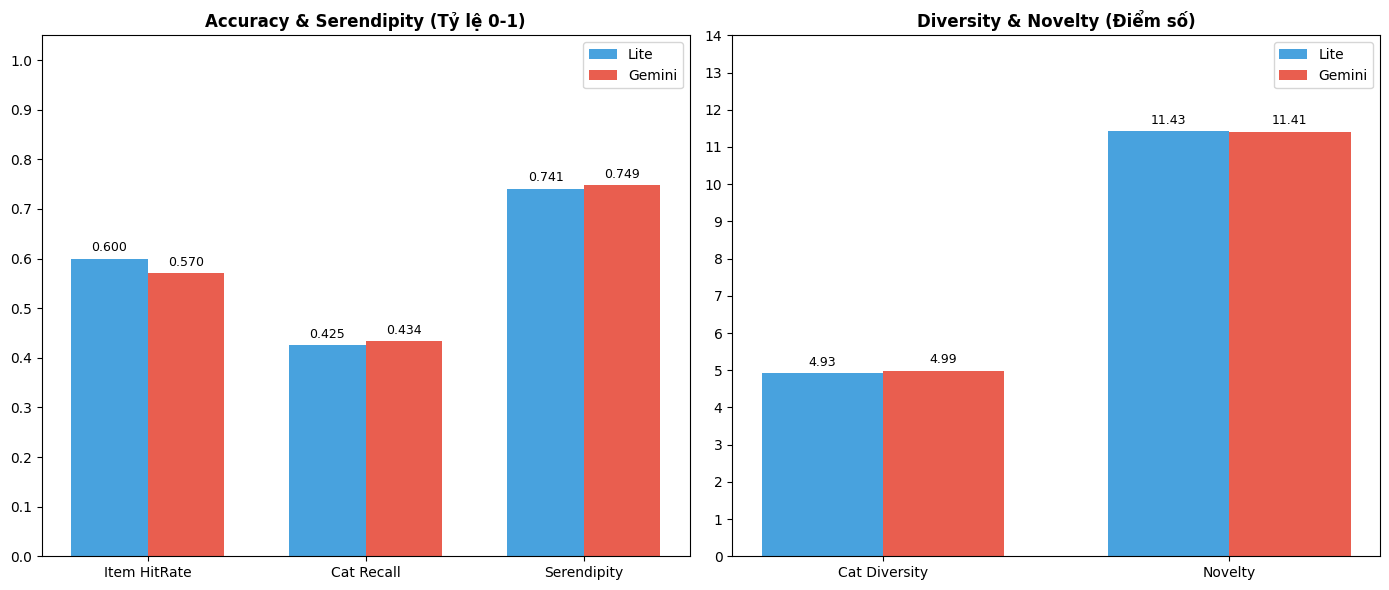

In [ ]:
def plot_comparison_visual_detailed(df_res):
    r = df_res.to_dict("records")
    if len(r) != 2: return
    
    lite_data, gem_data = r[0], r[1]

    # Nhóm 1: Ratio (0-1)
    metrics_acc = {
        "Item HitRate": "HitRate@K_e2e",
        "Cat Recall": "CatRecall@K_e2e",
        "Serendipity": "Serendipity@K_e2e"
    }
    
    # Nhóm 2: Score (>1)
    metrics_score = {
        "Cat Diversity": "CatDiversity@K_e2e",
        "Novelty": "Novelty@K_e2e"
    }

    def get_vals(metrics_dict):
        labels = list(metrics_dict.keys())
        l_vals = [lite_data.get(f"{k}_lite", 0) for k in metrics_dict.values()]
        g_vals = [gem_data.get(f"{k}_gemini", 0) for k in metrics_dict.values()]
        return labels, l_vals, g_vals

    # Setup plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Biểu đồ 1: Accuracy (0-1) ---
    labels1, l1, g1 = get_vals(metrics_acc)
    x1 = np.arange(len(labels1))
    width = 0.35
    
    rects1_l = ax1.bar(x1 - width/2, l1, width, label='Lite', color='#3498db', alpha=0.9)
    rects1_g = ax1.bar(x1 + width/2, g1, width, label='Gemini', color='#e74c3c', alpha=0.9)
    
    ax1.set_title('Accuracy & Serendipity (Tỷ lệ 0-1)', fontsize=12, fontweight='bold')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(labels1, fontsize=10)
    
    # --- CHỈNH ĐỘ CHIA CHI TIẾT 0.1 ---
    ax1.set_ylim(0, 1.05) 
    ax1.yaxis.set_major_locator(MultipleLocator(0.1)) # Vạch chia 0.1 theo yêu cầu
    
    ax1.legend()
    # Hiển thị 3 số lẻ
    ax1.bar_label(rects1_l, padding=3, fmt='%.3f', fontsize=9)
    ax1.bar_label(rects1_g, padding=3, fmt='%.3f', fontsize=9)

    # --- Biểu đồ 2: Score (>1) ---
    labels2, l2, g2 = get_vals(metrics_score)
    x2 = np.arange(len(labels2))
    
    rects2_l = ax2.bar(x2 - width/2, l2, width, label='Lite', color='#3498db', alpha=0.9)
    rects2_g = ax2.bar(x2 + width/2, g2, width, label='Gemini', color='#e74c3c', alpha=0.9)
    
    ax2.set_title('Diversity & Novelty (Điểm số)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(labels2, fontsize=10)

    # --- CHỈNH ĐỘ CHIA CHI TIẾT HƠN CHO NHÓM ĐIỂM SỐ ---
    ax2.set_ylim(0, 14) 
    ax2.yaxis.set_major_locator(MultipleLocator(1)) # Vạch chia 1 đơn vị

    ax2.legend()
    ax2.bar_label(rects2_l, padding=3, fmt='%.2f', fontsize=9)
    ax2.bar_label(rects2_g, padding=3, fmt='%.2f', fontsize=9)

    plt.tight_layout()
    plt.show()

print("Đang vẽ biểu đồ chi tiết (Vạch chia 0.1 & Data 3 số lẻ)...")
plot_comparison_visual_detailed(df_cmp)